# 시계열 데이터

## 비트코인 데이터 읽기

데이터의 길이:  365 
앞쪽 5개 값: [[9190.2715342 ]
 [9172.58833257]
 [9395.06444588]
 [9530.79088535]
 [9617.37786138]]


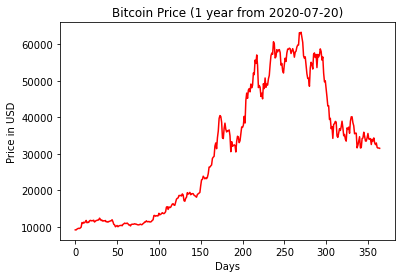

(358, 7, 1) (358, 1)
[[9190.2715342 ]
 [9172.58833257]
 [9395.06444588]
 [9530.79088535]
 [9617.37786138]
 [9568.97472596]
 [9708.9491401 ]] [9938.95122286]
[[34382.65069057]
 [33032.37773248]
 [32544.844908  ]
 [33003.81292216]
 [31783.1713495 ]
 [31596.29438325]
 [31640.91812684]] [31537.80518997]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 코인데스크 사이트에서 다운로드한 1년치 비트코인 가격 데이터 읽기
f = open('../data/BTC_USD_2020-07-20_2021-07-19-CoinDesk.csv', 'r')
coindesk_data = pd.read_csv(f, header=0)
seq = coindesk_data[['Closing Price (USD)']].to_numpy()
print('데이터의 길이: ', len(seq), '\n앞쪽 5개 값:', seq[0:5])

# 그래프로 데이터 확인
plt.plot(seq, color='red')
plt.title('Bitcoin Price (1 year from 2020-07-20)')
plt.xlabel('Days');plt.ylabel('Price in USD')
plt.show()

# 시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq, window, horizon):
    X=[]; Y=[]
    for i in range(len(seq) - (window + horizon) + 1):
        x = seq[i: (i+window)]
        y = (seq[i + window + horizon -1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w = 7
h = 1

X, Y = seq2dataset(seq, w, h)
print(X.shape, Y.shape)
print(X[0], Y[0]); print(X[-1], Y[-1])

## LSTM으로 시계열 예측하기


### LSTM을 이용한 비트코인 가격 예측

Epoch 1/200
250/250 - 1s - loss: 4167.4971 - mae: 4167.4971 - val_loss: 4140.3535 - val_mae: 4140.3535
Epoch 2/200
250/250 - 1s - loss: 1798.1107 - mae: 1798.1107 - val_loss: 3319.0105 - val_mae: 3319.0105
Epoch 3/200
250/250 - 1s - loss: 2382.5068 - mae: 2382.5068 - val_loss: 3167.4485 - val_mae: 3167.4485
Epoch 4/200
250/250 - 1s - loss: 1674.4152 - mae: 1674.4152 - val_loss: 3317.8896 - val_mae: 3317.8896
Epoch 5/200
250/250 - 1s - loss: 1659.4917 - mae: 1659.4917 - val_loss: 3609.8987 - val_mae: 3609.8987
Epoch 6/200
250/250 - 1s - loss: 1672.7625 - mae: 1672.7625 - val_loss: 3289.5747 - val_mae: 3289.5747
Epoch 7/200
250/250 - 1s - loss: 1696.3612 - mae: 1696.3612 - val_loss: 2833.2441 - val_mae: 2833.2441
Epoch 8/200
250/250 - 1s - loss: 1719.6655 - mae: 1719.6655 - val_loss: 2723.8420 - val_mae: 2723.8420
Epoch 9/200
250/250 - 1s - loss: 1603.5664 - mae: 1603.5664 - val_loss: 2543.1829 - val_mae: 2543.1829
Epoch 10/200
250/250 - 1s - loss: 1640.5503 - mae: 1640.5503 - val_loss: 

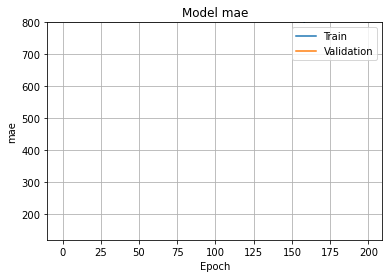

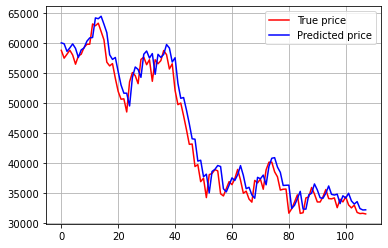

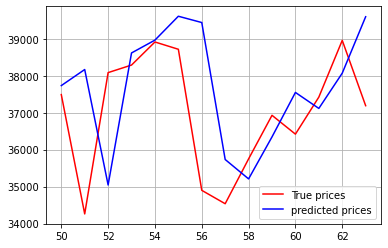

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 코인데스크 사이트에서 다운로드한 1년치 비트코인 가격 데이터 읽기
f = open('../data/BTC_USD_2020-07-20_2021-07-19-CoinDesk.csv', 'r')
coindesk_data = pd.read_csv(f, header=0)
seq = coindesk_data[['Closing Price (USD)']].to_numpy()

# 시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq, window, horizon):
    X=[]; Y=[]
    for i in range(len(seq) - (window + horizon) + 1):
        x = seq[i: (i+window)]
        y = (seq[i + window + horizon -1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w = 7
h = 1

X, Y = seq2dataset(seq, w, h)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 훈련 집합과 테스트 집합으로 분할
split = int(len(X) * 0.7)
x_train = X[0: split]; y_train = Y[0:split]
x_test = X[split:]; y_test = Y[split:]


# LSTM 모델 설계와 학습
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=x_train[0].shape))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
hist = model.fit(x_train, y_train, epochs=200, batch_size=1, validation_data=(x_test, y_test), verbose=2)

# LSTM 모델 평가
ev=model.evaluate(x_test, y_test, verbose=0)
print("손실 함수:", ev[0], 'MAE:', ev[1])

# LSTM 모델로 예측 수행
pred=model.predict(x_test)
print("평균절댓값백분율오차(MAPE):", sum(abs(y_test - pred)/y_test)/len(x_test))

# 학습 곡선
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title("Model mae")
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.ylim([120, 800])
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()

# 예측 결과 시각화
x_range = range(len(y_test))
plt.plot(x_range, y_test[x_range], color='red')
plt.plot(x_range, pred[x_range], color='blue')
plt.legend(['True price', 'Predicted price'], loc='best')
plt.grid()
plt.show()

# 일부 구간을 확대하여 시각화
x_range = range(50, 64)
plt.plot(x_range, y_test[x_range], color = 'red')
plt.plot(x_range, pred[x_range], color='blue')
plt.legend(['True prices', 'predicted prices'], loc='best')
plt.grid()
plt.show()

### 다중 채널 비트코인 가격 예측

(358, 7, 4) (358, 4)
[[3772.93633533 3796.63728431 3824.16587937 3666.52401643]
 [3799.67854295 3773.44146075 3879.23118467 3753.80002246]
 [3811.61197937 3799.36702601 3840.04482307 3788.91849833]
 [3804.41917011 3806.69151279 3819.19435612 3759.40921647]
 [3782.66410112 3807.84575592 3818.69548135 3766.24204823]
 [3689.86289319 3783.35506344 3804.35361623 3663.47774336]
 [3832.08088473 3701.04987103 3866.71870424 3688.69715385]] [3848.95636968 3832.59242908 3881.96576977 3802.51605364]
Epoch 1/200
250/250 - 1s - loss: 1019.3551 - mae: 1019.3551 - val_loss: 579.8367 - val_mae: 579.8367
Epoch 2/200
250/250 - 1s - loss: 510.3392 - mae: 510.3392 - val_loss: 345.7213 - val_mae: 345.7213
Epoch 3/200
250/250 - 1s - loss: 541.3934 - mae: 541.3934 - val_loss: 527.1516 - val_mae: 527.1516
Epoch 4/200
250/250 - 1s - loss: 535.9001 - mae: 535.9001 - val_loss: 341.9113 - val_mae: 341.9113
Epoch 5/200
250/250 - 1s - loss: 507.0651 - mae: 507.0651 - val_loss: 336.5572 - val_mae: 336.5572
Epoch 6/20

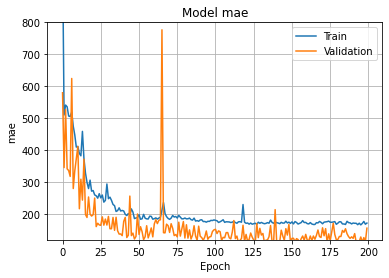

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 코인데스크 사이트에서 다운로드한 1년치 비트코인 가격 데이터 읽기
f = open('../data/BTC_USD_2019-02-28_2020-02-27-CoinDesk.csv', 'r')
coindesk_data = pd.read_csv(f, header=0)
seq = coindesk_data[['Closing Price (USD)', '24h Open (USD)', '24h High (USD)', '24h Low (USD)']].to_numpy()

# 시계열 데이터를 윈도우 단위로 자르는 함수
def seq2dataset(seq, window, horizon):
    X=[]; Y=[]
    for i in range(len(seq) - (window + horizon) + 1):
        x = seq[i: (i+window)]
        y = (seq[i + window + horizon -1])
        X.append(x); Y.append(y)
    return np.array(X), np.array(Y)

w = 7
h = 1

X, Y = seq2dataset(seq, w, h)
print(X.shape, Y.shape)
print(X[0], Y[0])

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# 훈련 집합과 테스트 집합으로 분할
split = int(len(X) * 0.7)
x_train = X[0: split]; y_train = Y[0:split]
x_test = X[split:]; y_test = Y[split:]


# LSTM 모델 설계와 학습
model = Sequential()
model.add(LSTM(units=128, activation='relu', input_shape=x_train[0].shape))
model.add(Dense(4))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
hist = model.fit(x_train, y_train, epochs=200, batch_size=1, validation_data=(x_test, y_test), verbose=2)

# LSTM 모델 평가
ev=model.evaluate(x_test, y_test, verbose=0)
print("손실 함수:", ev[0], 'MAE:', ev[1])

# LSTM 모델로 예측 수행
pred=model.predict(x_test)
print("평균절댓값백분율오차(MAPE):", sum(abs(y_test - pred)/y_test)/len(x_test))

# 학습 곡선
plt.plot(hist.history['mae'])
plt.plot(hist.history['val_mae'])
plt.title("Model mae")
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.ylim([120, 800])
plt.legend(['Train', 'Validation'], loc='best')
plt.grid()
plt.show()